In [22]:
# Basic imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

loan_data = pd.read_csv('raw_data/loans_v2.csv')

date_cols = [c for c in loan_data.columns if str(c)[-2:]=='Dt']
for col in date_cols:
    loan_data[col] = pd.to_datetime(loan_data[col], format='mixed')

In [23]:
loan_data.dtypes

GP                             int64
Note_Yr                        int64
Note_Mth                       int64
NoteDt                datetime64[ns]
LoanAmt                      float64
MaturityDt            datetime64[ns]
MaturityMthsQty                int64
PrepayDt              datetime64[ns]
PrepayMthsQty                float64
DefaultDt             datetime64[ns]
DefaultMthsQty               float64
PP_qty                       float64
MatBucket                     object
Code                         float64
CodeText                      object
Margin                       float64
MarginBucket                  object
state_abbreviation            object
state_name                    object
yr                           float64
dtype: object

In [24]:
loan_data.loc[loan_data['PrepayDt'] >= loan_data['DefaultDt'], 'PrepayMthsQty'] = np.NaN
loan_data.loc[loan_data['PrepayDt'] >= loan_data['DefaultDt'], 'PrepayDt'] = pd.NaT

In [25]:
loan_data.loc[loan_data['PrepayDt'] < loan_data['DefaultDt'], 'DefaultMthsQty' ] = np.NaN
loan_data.loc[loan_data['PrepayDt'] < loan_data['DefaultDt'], 'DefaultDt' ] = pd.NaT

In [26]:
display(loan_data[(loan_data['DefaultDt'].notna())&(loan_data['PrepayDt'].notna())])

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr


In [27]:
loan_data.loc[loan_data['DefaultMthsQty']>loan_data['PrepayMthsQty']]

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr


In [28]:
loan_data.loc[loan_data['Code'] == -1,'Code'] = np.NaN

In [29]:
loan_data.head(1)

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr
0,1502649,2000,7,2000-07-31,20600.0,2007-07-31,84,NaT,NaN,2006-03-06,67.0,67.0,0-8,459310.0,Florists,0.04,0.0275+,CT,Connecticut,2000.0


In [30]:
loan_data = loan_data[loan_data['MaturityMthsQty']>0]
loan_data = loan_data[loan_data['Note_Yr']<=2021]

loan_data = loan_data[[c for c in loan_data.columns if 'Bucket' not in c]]
# loan_data = loan_data[loan_data.columns[:-1]]

loan_data = loan_data[loan_data['LoanAmt']>1000]

In [33]:
loan_data = loan_data.drop(columns='yr')

In [46]:
loan_data['Code'] = loan_data['Code'].astype(str)
loan_data['Code'] = loan_data['Code'].str.replace('.0','')
loan_data.to_csv('presentable_loantapes/FOIA_loantape.csv')

In [47]:
loan_data

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,PP_qty,Code,CodeText,Margin,state_abbreviation,state_name
0,1502649,2000,7,2000-07-31,20600.00,2007-07-31,84,NaT,NaN,2006-03-06,67.0,67.0,459310,Florists,0.0400,CT,Connecticut
1,2019667,2001,2,2001-02-28,3600.00,2003-02-28,24,2002-01-30,11.0,NaT,NaN,11.0,441310,Automotive Parts and Accessories Stores,NaN,MS,Mississippi
2,2022516,2001,2,2001-02-28,60000.00,2011-02-27,119,NaT,NaN,2010-01-12,106.0,106.0,722514,"Cafeterias, Grill Buffets, and Buffets",0.0150,NY,New York
3,2039790,2001,7,2001-07-31,20000.02,2006-07-31,60,NaT,NaN,2003-12-31,29.0,29.0,561499,All Other Business Support Services,NaN,NC,North Carolina
4,2197720,2001,11,2001-11-30,50200.00,2006-11-30,60,NaT,NaN,2006-02-07,50.0,50.0,812990,All Other Personal Services,NaN,MI,Michigan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820421,17991919,2021,12,2021-12-31,150000.00,2031-12-07,119,NaT,NaN,NaT,NaN,NaN,nan,NaN,0.0275,FL,Florida
820422,17992033,2021,12,2021-12-16,1007700.00,2046-12-09,299,NaT,NaN,NaT,NaN,NaN,nan,NaN,0.0160,OH,Ohio
820423,17993054,2021,12,2021-12-16,441891.16,2046-12-08,299,NaT,NaN,NaT,NaN,NaN,nan,NaN,0.0000,TX,Texas
820426,17994055,2021,12,2021-12-30,2445298.50,2047-12-28,311,NaT,NaN,NaT,NaN,NaN,nan,NaN,0.0225,FL,Florida


In [3]:
# Filter to loans that have information we would get from a package and format columns for preprocessing
loan_data = loan_data[loan_data['Code'].notna()]
loan_data = loan_data[loan_data['Code']>0]
loan_data['Code'] = loan_data['Code'].astype(int)
loan_data = loan_data[loan_data['Margin'].notna()]

# Filter to all paid off loans
df = loan_data[loan_data['PP_qty'].notna()]
df['PP_label'] = ''
df.loc[df['PP_qty']>=48, 'PP_label'] = 1
df.loc[df['PP_qty']<48, 'PP_label'] = 0
df = df[df['LoanAmt'].notna()]
df = df[df['MatBucket'].notna()]
df.loc[df['MarginBucket'].isna(), 'MarginBucket'] = '0'
df = df[['LoanAmt','MaturityMthsQty','MatBucket','Code','Margin','MarginBucket','state_abbreviation','PP_qty','PP_label']]
df = df[df['MatBucket']=='21+']

df = df[['LoanAmt','MaturityMthsQty','Code','Margin','MarginBucket','state_abbreviation','PP_qty','PP_label']]


In [4]:
target_option = 'PP_label'

In [5]:

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor
# ML preprocessing imports
import sklearn.preprocessing as skp
# Create label encoder for buckets 
le = skp.LabelEncoder()
# Create dictionary for float scalers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df['Code'] = le.fit_transform(df['Code'])
df['MarginBucket'] = le.fit_transform(df['MarginBucket'])
df['state_abbreviation'] = le.fit_transform(df['state_abbreviation'])
X = df.drop(columns=['PP_qty','PP_label'])
y = df[target_option].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=1,
                                                    train_size=0.7)
amount_cols = ['LoanAmt', 'MaturityMthsQty']

scaler_dict = {c: None for c in amount_cols}

for key in scaler_dict.keys():
    scaler_dict[key] = skp.MinMaxScaler()
    X_train[key] = scaler_dict[key].fit_transform(X_train[key].values.reshape(-1,1))
    X_test[key] = scaler_dict[key].transform(X_test[key].values.reshape(-1,1))

if target_option != 'PP_label':
    rf = RandomForestRegressor(n_estimators=1000, random_state=1)
    rf.fit(X_train, y_train)
else:
    rf = BalancedRandomForestClassifier(n_estimators=500, random_state=1, max_depth=6)
    rf.fit(X_train, y_train)

ModuleNotFoundError: No module named 'imblearn'

In [94]:
y_pred = rf.predict(X_test)

In [99]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y_test,y_pred)
print('R-squared:', r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)
y_std = np.std(y)
print('RMSE:', rmse)
print(f'Coefficient of Variation: {y_std}')




R-squared: -0.8108272948810595
RMSE: 0.6705375335870037
Coefficient of Variation: 0.4982376730158466


In [96]:
pred_vs_actual = pd.DataFrame(dict(actual=y_test,predictions=y_pred)).reset_index().drop(columns='index')

In [97]:
pred_vs_actual

,actual,predictions
0,0,1
1,0,0
2,1,1
3,1,0
4,1,1
...,...,...
19894,1,1
19895,0,1
19896,1,1
19897,1,1


<AxesSubplot: title={'center': 'Features Importances: Top 10'}, ylabel='1'>

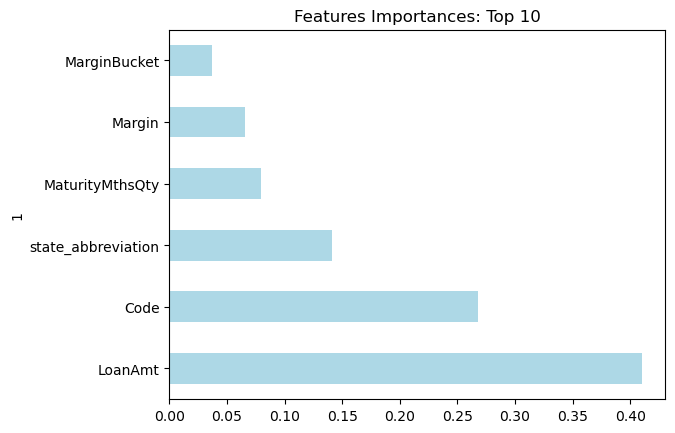

In [98]:

importances_df = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
importances_sorted.head(10).plot(kind='barh', color='lightblue', title= 'Features Importances: Top 10', legend=False)

In [ ]:

importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_df.set_index(importances_df[1], inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
importances_sorted.head(10).plot(kind='barh', color='lightblue', title= 'Features Importances: Top 10', legend=False)